In [1]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import math
import hitdifferentparts

In [2]:
import hitdifferentparts

In [3]:
w,t,pp,d,a = [3960.1349876368563, 0.09376144165196816, 0.0016713390753826927,
       0.0012821611585344935, 0.23768976773282824]
y = hitdifferentparts.getsounds_imp_gaus(10,10,0.5,0.5,w,t,pp,d,a,22050)

In [4]:
import ftm
y2 = ftm.getsounds_imp(10,10,w,t,pp,d,a,22050)

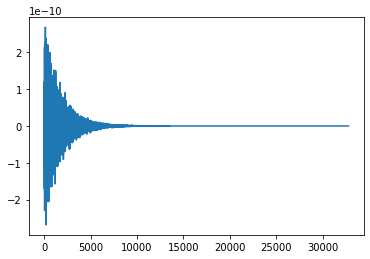

In [9]:
plt.plot(np.array(y[0])-np.array(y2[:2**15]))

In [5]:

def interpolate_sounds(x_coord,y_coord,num,prec,J,w,tau,p,D,alpha):
		"""
		x_coord, y_coord is the point at which you want to interpolate the sounds
		num is number of interpolation points
		prec is distance between interpolated to interpolation points
		"""
		scs = []
		sounds = []
		if num == 2:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord)]
		elif num == 4:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord),(x_coord,y_coord+prec),(x_coord,y_coord-prec)]
		for (x,y) in inter:
			y = hitdifferentparts.getsounds_imp_gaus(10,10,x,y,w,tau,p,D,alpha,22050)[0]
			Sy = getsc(torch.Tensor(y),J)
			sounds.append(y)
			scs.append(Sy)
		return sum(scs)/float(num),sounds


def interpolate_sounds_imp(x_coord,y_coord,num,prec,J,w,tau,p,D,alpha):
		"""
		x_coord, y_coord is the point at which you want to interpolate the sounds
		num is number of interpolation points
		prec is distance between interpolated to interpolation points
		"""
		scs = []
		sounds = []
		if num == 2:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord)]
		elif num == 4:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord),(x_coord,y_coord+prec),(x_coord,y_coord-prec)]
		for (x,y) in inter:
			y = hitdifferentparts.hitdiffparts(x,y,w,tau,p,D,alpha)
			Sy = getsc(torch.Tensor(y),J)
			sounds.append(y)
			scs.append(Sy)
		return sum(scs)/float(num),sounds
    
def getsc(y, J):
	"""
	this function outputs scattering transform of a time-domain signal.
	"""
	N = 2**15
	scattering = Scattering1D(J=J, shape=(N,), Q=1, max_order=2)
	Sy = scattering(y)
	return Sy

def interpolate_shape(x,y,num,prec,J,model_path,w,tau,p,D,alpha):
    #prepare scattering features 
	Sy_interpolated,sounds = interpolate_sounds(x,y,num,prec,J,w,tau,p,D,alpha)#this J should be small to recover sound	
	Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/1e-11)
	Sy_interpolated_log = Sy_interpolated_log.T
	n,m = Sy_interpolated_log.shape

	#prepare normalized ground truth
	scaler = getscaler()
	gt_original = np.array([w,tau,p,D,alpha]).reshape((1,5))
	gt_normalized = scaler.transform(gt_original)

	#prepare model
	model_best = create_model_adjustable(J,1,2,k_size=8,nchan_out=16,activation='linear')
	model_best.load_weights(model_path)
	hist = model_best.evaluate(np.array(Sy_interpolated_log).reshape(1,n,m),gt_normalized)
	model_predict = model_best.predict(Sy_interpolated_log.reshape(1,n,m))
	return hist,model_predict

def getscaler():
	df_train = pd.read_csv("../notebooks/train_param.csv")
	params = df_train.values[:,1:-1]
	for idx in range(2,4):
		params[:,idx] = [math.log10(i) for i in params[:,idx]]

	scaler = MinMaxScaler()
	scaler.fit(params)

	return scaler

def create_model_adjustable(J,Q,order,k_size,nchan_out,activation):
	N = 2**15
	y = np.random.rand(N)
	scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
	Sy = np.array(scattering(torch.Tensor(y))).T
	input_x,input_y = Sy.shape
	nchan_in = 1       # number of input channels.  1 since it is BW

	input_shape = (input_x,input_y)#Sy.shape
	kernel_size = (k_size,)
	K.clear_session()
	model=Sequential()
	#1 conv layer +  1 batch normalization + nonlinear activation + pooling
	model.add(BatchNormalization(input_shape=input_shape))
	model.add(Conv1D(filters=nchan_out,
		kernel_size=kernel_size, padding="same",name='conv1'))
	#model.add(BatchNormalization())
	model.add(Activation("relu"))

	if model.layers[-1].output_shape[1]>=4:
		pool = 4
	elif model.layers[-1].output_shape[1]==2:
		pool = 2
	    
	model.add(AveragePooling1D(pool_size=(pool,)))


	for i in range(3):
		model.add(Conv1D(filters=nchan_out,
		             kernel_size=kernel_size, padding="same" ))
		model.add(BatchNormalization())
		model.add(Activation("relu"))
		#print('before pool',model.layers[-1].output_shape)
		if model.layers[-1].output_shape[1] >= 4:
			model.add(AveragePooling1D(pool_size=(4,)))
		elif model.layers[-1].output_shape[1] == 2:
			model.add(AveragePooling1D(pool_size=(2,)))
		#print(model.layers[-1].output_shape)

	model.add(BatchNormalization())
	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(BatchNormalization())
	#what activation should be chosen for last layer, for regression problem? should be a linear function
	model.add(Dense(5, activation=activation)) #output layer that corresponds to the 5 physical parameters.


	# Compile the model
	model.compile(loss='mse', optimizer='adam', metrics=['mse'])




	return model



prepare model

sanity check!!

In [6]:
scaler = getscaler()

In [7]:
df_train = pd.read_csv("../notebooks/train_param.csv")
params = df_train.values[:,1:-1]
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

In [8]:
normalized_params = scaler.transform(params)
print(np.max(normalized_params))

1.0


In [9]:
df_val = pd.read_csv("../notebooks/val_param.csv")
val_params = df_val.values[:,1:-1]
for idx in range(2,4):
    val_params[:,idx] = [math.log10(i) for i in val_params[:,idx]]
normalized_val = scaler.transform(val_params)
print(np.min(normalized_val),np.max(normalized_val))

0.1999974300042483 0.7999925357985023


In [10]:
df_test = pd.read_csv("../notebooks/test_param.csv")
test_params = df_test.values[:,1:-1]
for idx in range(2,4):
    test_params[:,idx] = [math.log10(i) for i in test_params[:,idx]]
normalized_test = scaler.transform(test_params)
print(np.min(normalized_test),np.max(normalized_test))

2.411965301263308e-06 0.9999778201015369


In [11]:
output_dir = "/home/hh2263/wave2shape/sbatch/07_train10trials/output/10trials_3/"
j_best = 8
trial_best = 3
pickle_name = "_".join(
                ["J-" + str(j_best).zfill(2), "Q-" + str(1).zfill(2), "order" + str(2)]
            )
best_model_path = os.path.join(output_dir,"tests"+str(trial_best)+"/"+pickle_name+".h5")
print(best_model_path)
#prepare model
model_best = create_model_adjustable(j_best,1,2,k_size=8,nchan_out=16,activation='linear')
model_best.load_weights(best_model_path)

/home/hh2263/wave2shape/sbatch/07_train10trials/output/10trials_3/tests3/J-08_Q-01_order2.h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
val_theta = pd.read_csv("val_param.csv").values[:,1:-1]
test_theta = pd.read_csv("test_param.csv").values[:,1:-1]
print(val_theta.shape,test_theta.shape)

(7776, 5) (10000, 5)


normalize input features output ground truth labels
## predict on interpolated from validation set

In [13]:
num = 20
eps = 1e-3

In [14]:
import ftm

In [15]:
#pick random 20 from val_theta, collect interpolate scattering, 
rand_pick = np.arange(0,7776,1)
np.random.shuffle(rand_pick)
Sy_inters = []
Sy_accs = []
y_gt = []
for idx in rand_pick[:num]:
    w = val_theta[idx,0]
    tau = val_theta[idx,1]
    p = val_theta[idx,2] #don't normalize here, normalize later
    D = val_theta[idx,3]
    alpha = val_theta[idx,4]
    
    Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,j_best,w,tau,p,D,alpha)#gaussian
    Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/eps)
    y_acc = ftm.getsounds_imp(10,10,w,tau,p,D,alpha,sr=22050)[:2**15] #gaussian
    y_acc = y_acc/max(y_acc)
    #y_acc = hitdifferentparts.hitdiffparts(0.5,0.5,w,tau,p,D,alpha)
    Sy_acc = getsc(torch.Tensor(y_acc),j_best)
    Sy_acc_log = np.log1p(((Sy_acc>0)*Sy_acc)/eps)
    print(np.linalg.norm(Sy_acc_log-Sy_interpolated_log))
    Sy_accs.append(np.array(Sy_acc_log.T))
    Sy_inters.append(np.array(Sy_interpolated_log.T))
    y_gt.append([w,tau,p,D,alpha])
Sy_inters = np.array(Sy_inters).reshape((num,128,43))
Sy_accs = np.array(Sy_accs).reshape((num,128,43))
y_gt = np.array(y_gt)
print(Sy_inters.shape,y_gt.shape)

47.14
52.04522
50.016373
36.9299
41.520363
59.42938
50.941822
44.087452
44.059322
38.084038
57.039375
52.24547
39.904003
55.431625
52.746155
41.09847
33.629097
42.701015
37.22461
40.876804
(20, 128, 43) (20, 5)


In [16]:
# correct y_gt_val and normalize it
y_gt_val=y_gt
for idx in range(2,4):
    y_gt_val[:,idx] = [math.log10(i) for i in y_gt[:,idx]]
gt_normalized_val = scaler.transform(np.array(y_gt_val))
print(np.max(gt_normalized_val),np.min(gt_normalized_val))

0.7945289474700878 0.20640303575965901


In [17]:
#evaluate error
error_inter_val = []
error_acc_val = []
for i in range(num):
    e1 = model_best.evaluate(Sy_inters[i,:,:].reshape(1,128,43),gt_normalized_val[i,:].reshape((1,5)))
    e2 = model_best.evaluate(Sy_accs[i,:,:].reshape(1,128,43),gt_normalized_val[i,:].reshape((1,5)))
    error_inter_val.append(e1[0])
    error_acc_val.append(e2[0])

1/1 [==============================] - 0s 2ms/sample - loss: 0.0049 - mean_squared_error: 0.0049


In [18]:
worse=[]
better=[]
np.array(error_inter_val)>0.2
for idx,i in enumerate(error_inter_val):
    #print(idx,i)
    if i > 0.08:
        worse.append(gt_normalized_val[idx,:])
    else:
        better.append(gt_normalized_val[idx,:])
        

In [19]:
print(len(worse),len(better))

4 16


Text(0.5, 1.0, 'better in val')

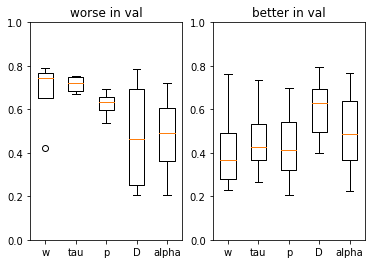

In [20]:
plt.subplot(1,2,1)
plt.boxplot(np.array(worse),labels=["w","tau","p","D","alpha"])
plt.ylim([0,1])
plt.title("worse in val")
plt.subplot(1,2,2)
plt.boxplot(np.array(better),labels=["w","tau","p","D","alpha"])
plt.ylim([0,1])
plt.title("better in val")

In [21]:
print(error_acc_val,error_acc_val)

[0.050373148173093796, 0.016720157116651535, 0.026268795132637024, 0.02021244540810585, 0.010143881663680077, 0.012208248488605022, 0.006137226242572069, 0.008286748081445694, 0.021882066503167152, 0.01411501131951809, 0.0008552317740395665, 0.008148392662405968, 0.007764423731714487, 0.013341402634978294, 0.017825007438659668, 0.02774767018854618, 0.009542206302285194, 0.03495200350880623, 0.02818448469042778, 0.004862205125391483] [0.050373148173093796, 0.016720157116651535, 0.026268795132637024, 0.02021244540810585, 0.010143881663680077, 0.012208248488605022, 0.006137226242572069, 0.008286748081445694, 0.021882066503167152, 0.01411501131951809, 0.0008552317740395665, 0.008148392662405968, 0.007764423731714487, 0.013341402634978294, 0.017825007438659668, 0.02774767018854618, 0.009542206302285194, 0.03495200350880623, 0.02818448469042778, 0.004862205125391483]


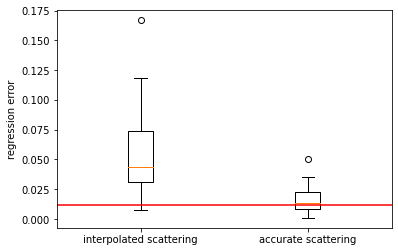

In [22]:
plt.boxplot([error_inter_val,error_acc_val],labels=["interpolated scattering","accurate scattering"])
plt.ylabel('regression error')
#plt.xlabel('Interpolated Scattering')
#plt.ylim([0,0.4])
plt.axhline(y=0.012,color = 'r')


## predict on interpolated from test set

In [23]:
#pick random 20 from val_theta, collect interpolate scattering, 
rand_pick_2 = np.arange(0,10000,1)
np.random.shuffle(rand_pick_2)
Sy_inters_test = []
Sy_accs_test = []
y_gt_test = []
for idx in rand_pick_2[:num]:
    w = test_theta[idx,0]
    tau = test_theta[idx,1]
    p = test_theta[idx,2]
    D = test_theta[idx,3]
    alpha = test_theta[idx,4] 
    
    Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,j_best,w,tau,p,D,alpha)
    Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/eps)
    y_acc = ftm.getsounds_imp(10,10,w,tau,p,D,alpha,sr=22050)[:2**15] #gaussian
    y_acc = y_acc/max(y_acc)
    #y_acc = hitdifferentparts.hitdiffparts(0.5,0.5,w,tau,p,D,alpha)
    Sy_acc = getsc(torch.Tensor(y_acc),j_best)
    Sy_acc_log = np.log1p(((Sy_acc>0)*Sy_acc)/eps)
    
    Sy_accs_test.append(np.array(Sy_acc_log.T))
    Sy_inters_test.append(np.array(Sy_interpolated_log.T))
    y_gt_test.append([w,tau,p,D,alpha])

Sy_inters_test = np.array(Sy_inters_test).reshape((num,128,43))
Sy_accs_test = np.array(Sy_accs_test).reshape((num,128,43))
y_gt_test = np.array(y_gt_test)
print(Sy_inters_test.shape,y_gt_test.shape)

(20, 128, 43) (20, 5)


In [24]:
# correct y_gt_test
for idx in range(2,4):
    y_gt_test[:,idx] = [math.log10(i) for i in y_gt_test[:,idx]]
gt_original_test = np.array(y_gt_test)
gt_normalized_test = scaler.transform(gt_original_test)
print(np.max(gt_normalized_test),np.min(gt_normalized_test))

0.9832231349383874 0.007361443291034206


In [25]:
#gt_original_test = np.array(y_gt_test)
#gt_normalized_test = scaler.transform(gt_original_test)
#prepare model
#hist = model_best.evaluate(Sy_inters.reshape(20,128,43),gt_normalized)
error_inter_test = []
error_acc_test = []
for i in range(num):
    e1 = model_best.evaluate(Sy_inters_test[i,:,:].reshape(1,128,43),gt_normalized_test[i,:].reshape((1,5)))
    e2 = model_best.evaluate(Sy_accs_test[i,:,:].reshape(1,128,43),gt_normalized_test[i,:].reshape((1,5)))
    error_inter_test.append(e1[0])
    error_acc_test.append(e2[0])

1/1 [==============================] - 0s 2ms/sample - loss: 0.0459 - mean_squared_error: 0.0459


Text(0.5, 1.0, 'better in test')

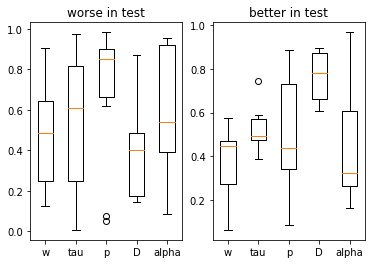

In [26]:
worse_test=[]
better_test=[]
np.array(error_inter_test)>0.2
for idx,i in enumerate(error_inter_test):
    #print(idx,i)
    if i > 0.1:
        worse_test.append(gt_normalized_test[idx,:])
    else:
        better_test.append(gt_normalized_test[idx,:])

plt.subplot(1,2,1)
plt.boxplot(np.array(worse_test),labels=["w","tau","p","D","alpha"])
#plt.ylim([0,1])
plt.title("worse in test")
plt.subplot(1,2,2)
plt.boxplot(np.array(better_test),labels=["w","tau","p","D","alpha"])
#plt.ylim([0,1])
plt.title("better in test") 

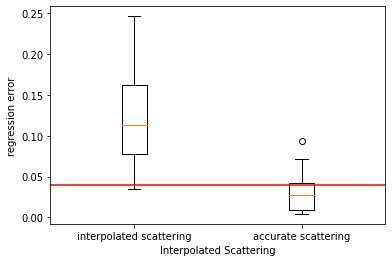

In [27]:
plt.boxplot([error_inter_test,error_acc_test],labels=["interpolated scattering","accurate scattering"])
plt.ylabel('regression error')
plt.xlabel('Interpolated Scattering')
#plt.ylim([0,0.8])
plt.axhline(y=0.04,color = 'r')

## predict on random interpolated

In [28]:
omega = list(np.linspace(200*np.pi,4000*np.pi,20))
tau = list(np.linspace(0.01,0.3,20))
p = list(np.logspace(np.log10(0.0001),np.log10(2),20))
D = list(np.logspace(np.log10(0.0001),np.log10(10),20))
alpha = list(np.linspace(0.001,1,20))

In [29]:
Sy_inters_random=[]
Sy_accs_random = []
y_gt_random=[]
for i in range(num):
    w = np.random.choice(omega)
    t = np.random.choice(tau)
    pp = np.random.choice(p)
    d = np.random.choice(D)
    a = np.random.choice(alpha)
    Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,j_best,w,t,pp,d,a)
    Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/eps)
    Sy_inters_random.append(np.array(Sy_interpolated_log.T))
    
    y_acc = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15] #gaussian
    y_acc = y_acc/max(y_acc)
    #y_acc = hitdifferentparts.hitdiffparts(0.5,0.5,w,t,pp,d,a)
    Sy_acc = getsc(torch.Tensor(y_acc),j_best)
    Sy_acc_log = np.log1p(((Sy_acc>0)*Sy_acc)/eps)
    Sy_accs_random.append(np.array(Sy_acc_log.T))
    
    y_gt_random.append([w,t,pp,d,a])
Sy_inters_random = np.array(Sy_inters_random).reshape((num,128,43))
Sy_accs_random = np.array(Sy_accs_random).reshape((num,128,43))
y_gt_random = np.array(y_gt_random)
print(Sy_inters_random.shape,y_gt_random.shape)
    

(20, 128, 43) (20, 5)


In [30]:
#correct y_gt_random
for idx in range(2,4):
    y_gt_random[:,idx] = [math.log10(i) for i in y_gt_random[:,idx]]
gt_original_random = np.array(y_gt_random)
gt_normalized_random = scaler.transform(gt_original_random)
print(np.max(gt_normalized_random),np.min(gt_normalized_random))

1.0000045732725678 -2.5760331309909734e-05


In [31]:
#gt_original_random = np.array(y_gt_random)
#print(gt_original_random[0])
#gt_normalized_random = scaler.transform(gt_original_random)
#prepare model
#hist = model_best.evaluate(Sy_inters.reshape(20,128,43),gt_normalized)
error_inter_random = []
error_acc_random = []
for i in range(num):
    e1 = model_best.evaluate(Sy_inters_random[i,:,:].reshape(1,128,43),gt_normalized_random[i,:].reshape((1,5)))
    e2 = model_best.evaluate(Sy_accs_random[i,:,:].reshape(1,128,43),gt_normalized_random[i,:].reshape((1,5)))
    error_inter_random.append(e1[0])
    error_acc_random.append(e2[0])
    

1/1 [==============================] - 0s 2ms/sample - loss: 0.0068 - mean_squared_error: 0.0068


Text(0.5, 1.0, 'better in random')

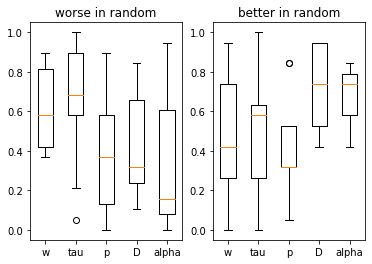

In [32]:
worse_random=[]
better_random=[]
np.array(error_inter_random)>0.2
for idx,i in enumerate(error_inter_random):
    #print(idx,i)
    if i > 0.1:
        worse_random.append(gt_normalized_random[idx,:])
    else:
        better_random.append(gt_normalized_random[idx,:])

plt.subplot(1,2,1)
plt.boxplot(np.array(worse_random),labels=["w","tau","p","D","alpha"])
#plt.ylim([0,3])
plt.title("worse in random")
plt.subplot(1,2,2)
plt.boxplot(np.array(better_random),labels=["w","tau","p","D","alpha"])
#plt.ylim([0,3])
plt.title("better in random") 

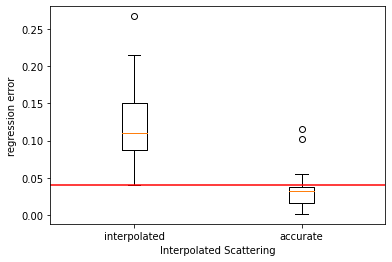

In [33]:
plt.boxplot([error_inter_random,error_acc_random],labels=["interpolated","accurate"])
plt.ylabel('regression error')
plt.xlabel('Interpolated Scattering')
#plt.ylim([0,1])
plt.axhline(y=0.04,color = 'r')

In [34]:
print(np.max(error_inter_val),np.max(error_acc_val),
      np.max(error_inter_test),np.max(error_acc_test),
      np.max(error_inter_random),np.max(error_acc_random))


0.16689889132976532 0.050373148173093796 0.24622969329357147 0.0939934104681015 0.26672548055648804 0.11620541661977768


In [68]:
error_total = np.stack([np.array(error_val),np.array(error_test),np.array(error_random)]).reshape(num,3)

NameError: name 'error_val' is not defined

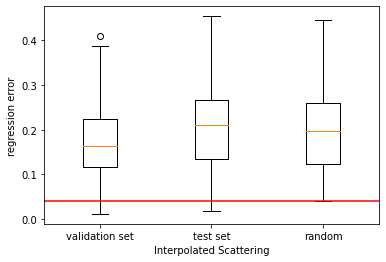

In [105]:
labels=['validation set','test set','random']
plt.boxplot(error_total,labels=labels)
plt.ylabel('regression error')
plt.xlabel('Interpolated Scattering')
#plt.ylim([0,0.8])
plt.axhline(y=0.04,color = 'r')

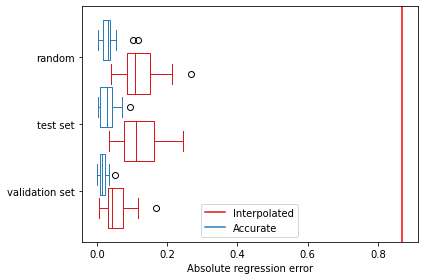

In [69]:

error_inter = [error_inter_val, error_inter_test, error_inter_random]
error_acc = [error_acc_val, error_acc_test, error_acc_random]

ticks = ['validation set', 'test set', 'random']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

#bpl = plt.boxplot(error_inter, positions=np.array(range(len(error_inter)))*2.0-0.4, sym='', widths=0.6,vert=False)
#bpr = plt.boxplot(error_acc, positions=np.array(range(len(error_acc)))*2.0+0.4, sym='', widths=0.6,vert=False)
bpl = plt.boxplot(error_inter, widths=0.6,vert=False,positions = np.array(range(0, len(ticks)))+0.25) 
bpr = plt.boxplot(error_acc, widths=0.6,vert=False,positions = np.array(range(0, len(ticks)))+0.75)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Interpolated')
plt.plot([], c='#2C7BB6', label='Accurate')
plt.legend()

plt.yticks(np.array(range(0, len(ticks)))+0.5, ticks)
#plt.yticks(range(0, len(ticks) * 2, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.xlim([0,1])
#plt.ylim([0, 1])
plt.xlabel("Absolute regression error")
plt.axvline(x=0.87,color = 'r')
plt.tight_layout()

In [72]:
df_val

,Unnamed: 0,omega,tau,p,D,alpha,set
0,22222,3960.134988,0.093761,0.001671,0.001282,0.237690,val
1,22223,3630.680903,0.094744,0.001536,0.002765,0.316667,val
2,22224,4167.797085,0.074728,0.001385,0.001089,0.461587,val
3,22225,3215.863837,0.091230,0.001901,0.002746,0.598406,val
4,22226,4066.782177,0.077409,0.001313,0.001362,0.633778,val
...,...,...,...,...,...,...,...
7771,77773,10051.532708,0.228197,0.205187,0.994889,0.311660,val
7772,77774,9367.309465,0.235730,0.209723,0.903597,0.482831,val
7773,77775,9479.537443,0.235686,0.254595,0.506088,0.583378,val
7774,77776,9485.453520,0.231557,0.272010,0.327080,0.627932,val


In [10]:
w,t,pp,d,a = val_theta[1,:]

sanity check on why accurate performs worth than interpolated

In [20]:
#normalize gt
gt = np.array([w,t,math.log10(pp),math.log10(d),a]).reshape((1,5))
gt_normalized = scaler.transform(gt)

In [54]:
import ftm
j = 8
eps = 1e-3
w,t,pp,d,a = val_theta[2,:]
#load original sound
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22224_sound.wav") # file is synthesized with 44100 and 2**16, but somehow with 22050 and 2**15, sounds the same with 44100 and 2**15
Sy_original = getsc(torch.Tensor(sound),j)
Sy_original_log = np.log1p(((Sy_original>0)*Sy_original)/eps)
#algorithm gaussian excitation
y_acc2 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
y_acc2 = y_acc2/ max(y_acc2)
#y_acc2[0] = 0.01
Sy_acc2 = getsc(torch.Tensor(y_acc2),j)
Sy_acc_log2 = np.log1p(((Sy_acc2>0)*Sy_acc2)/eps)
#interpolated feature with gaussian
Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,j,w,t,pp,d,a)
Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/eps)
#interpolated feature with delta
Sy_interpolated2,sounds2 = interpolate_sounds_imp(0.5,0.5,4,0.05,j,w,t,pp,d,a)
Sy_interpolated_log2 = np.log1p(((Sy_interpolated2>0)*Sy_interpolated2)/eps)
#accurate delta
y_hit = hitdifferentparts.hitdiffparts(0.5,0.5,w,t,pp,d,a) #5 modes, 2**15,delta excitation
Sy_hit = getsc(torch.Tensor(y_hit),j)
Sy_hit_log = np.log1p(((Sy_hit>0)*Sy_hit)/eps)
#accurate feature_pickle
"""
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'

J = 6
Q = 1
order = 2
pickle_name = "_".join(
	["scattering",
	"J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]
)
pkl_path_val = os.path.join(pkl_dir,pickle_name+"_fold-val.pkl")
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_pik = Sy_val[2,:,:]
Sy_pik = np.log1p(((Sy_pik>0)*Sy_pik)/eps)
"""

--- 1.0235588550567627 seconds ---
--- 1.0123965740203857 seconds ---
--- 1.0211513042449951 seconds ---
--- 1.0176825523376465 seconds ---
--- 1.0259456634521484 seconds ---


'\npkl_dir = \'/scratch/hh2263/drum_data/han2020fa_sc-pkl/\'\n\nJ = 6\nQ = 1\norder = 2\npickle_name = "_".join(\n\t["scattering",\n\t"J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]\n)\npkl_path_val = os.path.join(pkl_dir,pickle_name+"_fold-val.pkl")\npkl_val = open(pkl_path_val,\'rb\')\nSy_val,y_val = pickle.load(pkl_val)\nSy_pik = Sy_val[2,:,:]\nSy_pik = np.log1p(((Sy_pik>0)*Sy_pik)/eps)\n'

In [23]:
print(sound[0:3],y_acc2[0:3])

[0.0091733  0.10096264 0.19835451] [0.01       0.10292627 0.19722386]


In [18]:
np.linalg.norm(Sy_original_log-Sy_acc_log2)

0.019657852

In [26]:
original_err = model_best.evaluate(Sy_original_log.T.reshape(1,128,43),gt_normalized.reshape((1,5)))
acc_gau = model_best.evaluate(Sy_acc_log2.T.reshape(1,128,43),gt_normalized.reshape((1,5)))#debug corruption skip sample
inter_gau = model_best.evaluate(Sy_interpolated_log.T.reshape(1,128,43),gt_normalized.reshape((1,5)))
inter_del = model_best.evaluate(Sy_interpolated_log2.T.reshape(1,128,43),gt_normalized.reshape((1,5)))
acc_del = model_best.evaluate(Sy_hit_log.T.reshape(1,128,43),gt_normalized.reshape((1,5)))

1/1 [==============================] - 0s 4ms/sample - loss: 0.0423 - mean_squared_error: 0.0423


In [21]:
original_err = model_best.evaluate(Sy_original_log.T.reshape(1,512,26),gt_normalized.reshape((1,5)))
acc_gau = model_best.evaluate(Sy_acc_log2.T.reshape(1,512,26),gt_normalized.reshape((1,5)))#debug corruption skip sample
inter_gau = model_best.evaluate(Sy_interpolated_log.T.reshape(1,512,26),gt_normalized.reshape((1,5)))
inter_del = model_best.evaluate(Sy_interpolated_log2.T.reshape(1,512,26),gt_normalized.reshape((1,5)))
acc_del = model_best.evaluate(Sy_hit_log.T.reshape(1,512,26),gt_normalized.reshape((1,5)))
#acc_pik = model_best.evaluate(Sy_pik.reshape(1,512,26),gt_normalized.reshape((1,5)))
#acc_gau2 = model_best.evaluate(Sy_acc_log2.T.reshape(1,512,26),gt_normalized.reshape((1,5)))#debug corruption wrong sr

1/1 [==============================] - 0s 3ms/sample - loss: 0.0507 - mean_squared_error: 0.0507


In [19]:
pkl_path

NameError: name 'pkl_path' is not defined

pick a random shape in validation set and make its reconstructed sound

In [72]:
idx = 30
w = val_theta[idx,0]
tau = val_theta[idx,1]
p = val_theta[idx,2] #don't normalize here, normalize later
D = val_theta[idx,3]
alpha = val_theta[idx,4]
#normalize ground truth
#y_gt = np.array([w,tau,p,D,alpha])

#make interpolation scattering
Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,j_best,w,tau,p,D,alpha)#gaussian
Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/eps)
#make accurate sound
y_acc = ftm.getsounds_imp(10,10,w,tau,p,D,alpha,sr=22050)[:2**15] #gaussian
y_acc = y_acc/max(y_acc)
#predict on interpolated scattering
predicted_gt = model_best.predict(Sy_interpolated_log.reshape((1,128,43)))
print(predicted_gt)

[[0.27263865 0.41819388 0.3543402  0.8587289  0.60700464]]


In [82]:
recovered_gt = scaler.inverse_transform(predicted_gt)[0]
#print(recovered_gt)
recovered_gt[2] = 10**recovered_gt[2]
recovered_gt[3] = 10**recovered_gt[3]
#for idx in range(2,4):
#    recovered_gt[idx] = [10**i for i in params[:,idx]]
print(recovered_gt,[w,tau,p,D,alpha])

[3.8830176e+03 1.3128002e-01 3.3422434e-03 1.9659059e+00 6.0737729e-01] [3071.9656812723842, 0.07216129725588387, 0.0015521863199869715, 0.4556260155391533, 0.2350724840042392]


In [83]:
w_2,tau_2,p_2,D_2,alpha_2 = recovered_gt
y_reconstructed = ftm.getsounds_imp(10,10,w_2,tau_2,p_2,D_2,alpha_2,sr=22050)[:2**15] #gaussian

In [92]:
import soundfile as sf

In [96]:
ipd.Audio(y_acc,rate=22050)
fs=22050
filename = 'accuratesound.wav'
sf.write(filename, y_acc/max(y_acc), fs)

In [97]:
y_reconstructed_corrected = ftm.getsounds_imp(10,10,w,tau_2,p_2,D_2,alpha_2,sr=22050)[:2**15] #gaussian
ipd.Audio(y_reconstructed_corrected,rate=22050)
filename = 'reconstructed_corrected.wav'
sf.write(filename, y_reconstructed_corrected/max(y_reconstructed_corrected), fs)

In [98]:
ipd.Audio(y_reconstructed,rate=22050)
filename = 'reconstructed.wav'
sf.write(filename, y_reconstructed/max(y_reconstructed), fs)

In [13]:
#skip sample - sound file
ipd.Audio(sound-y_acc,rate=44100)

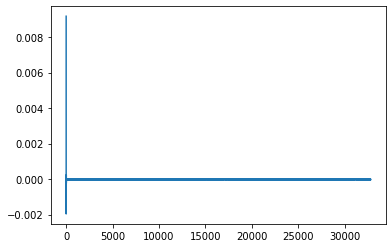

In [14]:
plt.plot(sound-y_acc)

## where does the sound file come from?? 
1. definitely the correct mode=10, as using a different mode yields significantly different results
2. with the same mode, first sample has the most difference
3. if they sound the same, with delta difference, how different would the scattering be

In [33]:
y_1 = ftm.getsounds_imp(5,5,w,t,pp,d,a,sr=22050)[:2**15]
y_2 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
y_3 = ftm.getsounds_imp(15,15,w,t,pp,d,a,sr=22050)[:2**15]
y_1 = y_1/max(y_1)
y_2 = y_2/max(y_2)
y_3 = y_3/max(y_3)

In [119]:
diff = np.array(torch.Tensor(Sy_pik)-Sy_original_log.T)
print(np.max(np.max(diff)))

0.21710652


In [124]:
diff2 = np.array(torch.Tensor(Sy_pik)-Sy_acc_log2.T)
print(np.max(np.max(diff2)),np.max(sound-y_acc2[:2**15]))

6.863162 0.060009356204637876


In [115]:
np.max(np.max((Sy_pik)-np.array(Sy_original_log.T)))

0.21710652

In [129]:
def getsc(y, J):
	"""
	this function outputs scattering transform of a time-domain signal.
	"""
	N = 2**15
	scattering = Scattering1D(J=J, shape=(N,), Q=1, max_order=2)
	Sy = scattering(y)
	return Sy


In [133]:
#get scattering of acc in different mode
sc1 = getsc(torch.Tensor(sound), 8)
sc1 = np.log1p(((sc1>0)*sc1)/1e-11)

In [142]:
np.min(np.array(Sy_acc_log.T-Sy_pik))

-6.863162

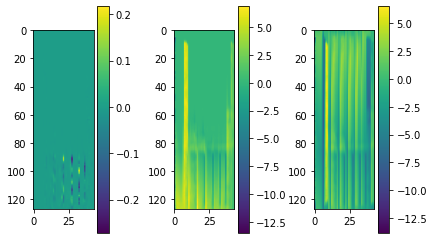

In [144]:
plt.subplot(1,3,1)
plt.imshow(torch.Tensor(Sy_pik)-Sy_original_log.T)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.Tensor(Sy_pik)-Sy_acc_log.T)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(torch.Tensor(Sy_pik)-Sy_hit_log.T)
plt.colorbar()
plt.tight_layout()
plt.show()

In [157]:
y_new = ftm.getsounds_imp(10,10,w*1.1,t,pp,d,a,sr=22050)[:2**15]
y_new = y_new/max(y_new)
sc_new = getsc(torch.Tensor(y_new), 8)
sc_new = np.log1p(((sc_new>0)*sc_new)/1e-11)

y_p = ftm.getsounds_imp(10,10,w,t,pp*1.1,d,a,sr=22050)[:2**15]
y_p = y_p/max(y_p)
sc_p = getsc(torch.Tensor(y_p), 8)
sc_p = np.log1p(((sc_p>0)*sc_p)/1e-11)



In [158]:
ipd.Audio(sound,rate=22050)

In [159]:
ipd.Audio(y_p,rate=22050)

In [160]:
ipd.Audio(sound-y_p,rate=22050)

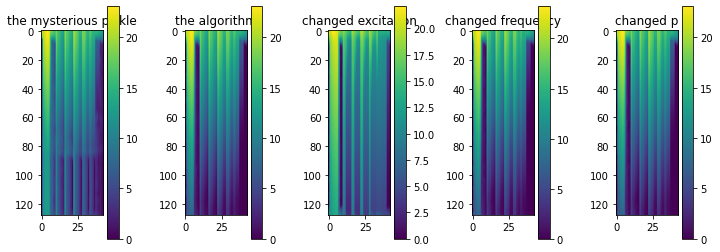

In [162]:
plt.figure(figsize=(10, 6))
plt.subplot(1,5,1)
plt.imshow(torch.Tensor(Sy_pik))
plt.title("the mysterious pickle")
plt.colorbar()
plt.subplot(1,5,2)
plt.imshow(Sy_acc_log.T)
plt.title("the algorithm")
plt.colorbar()
plt.subplot(1,5,3)
plt.imshow(Sy_hit_log.T)
plt.title("changed excitation")
plt.colorbar()
plt.subplot(1,5,4)
plt.title("changed frequency")
plt.imshow(sc_new.T)
plt.colorbar()
plt.subplot(1,5,5)
plt.title("changed p")
plt.imshow(sc_p.T)
plt.colorbar()
plt.tight_layout()
plt.show()

In [180]:
#test on random files
y_rand = np.random.random(2**15)
y_rand2 = y_rand+np.random.random(2**15)*0.1
y_rand2[0] = y_rand2[0]+0.9

In [181]:
y_rand-y_rand2
sc = getsc(torch.Tensor(y_rand), 8)
sc = np.log1p(((sc>0)*sc)/1e-11)
sc2 = getsc(torch.Tensor(y_rand2), 8)
sc2 = np.log1p(((sc2>0)*sc2)/1e-11)

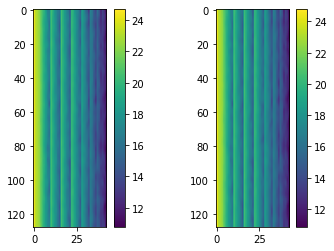

In [182]:
plt.subplot(1,2,1)
plt.imshow(sc.T)

plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sc2.T)

plt.colorbar()